# Online Payment Fraud   👩🏻‍✈️   🚨  🧟‍♂️ 

#### Background: 
Online payment fraudulent transaction are imperceptibly concealed. Fraudsters often come up with new methods to steal customer or company sensitive data through email, messaging, rerouting traffic to fraudulent websites, or phone calls, etc. After collecting these data, they can easily fake their identity, which we may think they are just normal subjects in the system. Thus, to discover the patterns behind these fraudulent transaction can be challenge. 

#### Task:
In this assessment, we use the online payment transaction dataset.

We have total 594,643 transactions and background information about 4,112 customers and 50 merchants over **180 num of time (unit unknown)** in data. Total 9 categorical features and 2 numerical features. 

This is a supervised learning (classification) problem, which the **target feature 'fruad'** is provided.

🎯 In order to minimize the loss for Ant Financial, its customers and involved merchants on the platform, we aim at predicting and detecting all potential fraud transactions by following processes. 

#### Overall Parts:
- **section 1 👩🏼‍💻 : ** Exploratory Data Analysis
- **section 2 👨🏻‍🔧 : ** Feature Engineering (including Node Embedding)
- **section 3 👩🏻‍🔬 : ** Fraud Detection Model Building & Evaluating

🚀 Ok, so let's start!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# read the transaction data 
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')

#train.shape   (296508, 11) with target 'fraud'
#test.shape    (298135, 10) without target 'fraud'

# merge train and test for feature engineering purpose 
df = pd.concat([train,test]) 

#df.shape      (594643, 11)

# 1.  👩🏼‍💻 Exploratory Data Analysis 
In this section, we check the correlation/relation between features.

### Summary key Insight: 
1. This is a heavily imbalanced data. (Need **resampling method**)
2. We claim that fraud class vs non_fraud class have different patterns.
3. Since the fraud ratio of different features are mostly in **wide range (w/ high std)**, there are many possibilities of fraud patterns targeting diverse backgrounds' customers or merchants. The fraud patterns are hard to observe directly.
4. Feature **'amount'💰** has relatively stronger influence on target feature 'fraud'. 
5. Fraudulent transactions are mostly involved with **high-value transactions 💸 ** (w/ high std)
6. We assume that fraud is **time independent**.

#### Data Description 

In [14]:
train.isnull().values.any()
test.isnull().values.any()
# Great! There are no null values in train & test set so we don't need to do data cleaning.

False

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594643 entries, 0 to 298134
Data columns (total 11 columns):
age_group           594643 non-null object
amount              594643 non-null float64
customer_id         594643 non-null object
fraud               296508 non-null float64
gender              594643 non-null object
id                  594643 non-null int64
merchant_id         594643 non-null object
time                594643 non-null int64
type                594643 non-null object
zipcode_customer    594643 non-null object
zipcode_merchant    594643 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 54.4+ MB


In [3]:
df.nunique().sort_values()

zipcode_customer         1
zipcode_merchant         1
fraud                    2
gender                   4
age_group                8
type                    15
merchant_id             50
time                   180
customer_id           4112
amount               23772
id                  298135
dtype: int64

#### Categorical Features w/ count
- age_group:

    - '2'    187310 (31.4% of transactions in df are from this age group )
    - '3'    147131 (24.7% ...)
    - '4'    109025
    - '5'     62642
    - '1'     58131
    - '6'     26774
    - '0'      2452
    - 'U'      1178


- gender: 
  - 'F': 324565 (54.5 % of transactions in df are from this age group )
  - 'M': 268385 (45.1 % ...)
  - 'E': 1178
  - 'U':515


- zipcode_customer: 
  - '28007'


- zipcode_merchant: 
  - '28007'


- type: 

   - 'es_transportation'        505119  (85% of transactions in df are from this type)
   - 'es_food'                   26254  (4.4% ...)
   - 'es_health'                 16133
   - 'es_wellnessandbeauty'      15086
   - 'es_fashion'                 6454
   - 'es_barsandrestaurants'      6373
   - 'es_hyper'                   6098
   - 'es_sportsandtoys'           4002
   - 'es_tech'                    2370
   - 'es_home'                    1986
   - 'es_hotelservices'           1744
   - 'es_otherservices'            912
   - 'es_contents'                 885
   - 'es_travel'                   728
   - 'es_leisure'                  499


- fraud (label) :  **only for train set**
  - 0.0 : 293052 (98.8% of transactions in train set are non fraud)
  - 1.0 : 3456   (1.2% ...) 
  
  
- customer_id 4112 
- merchant_id 50
- id (uniqe) 594643

#### Numerical Features
- time 0 ~ 179 
- amount 💰

#### check ratio of fraud to non-fraud transactions in train set

293052 non-fraudulent transactions (98.8%) & 3456 fraudulent transactions (1.2%).


0.0    293052
1.0      3456
Name: fraud, dtype: int64

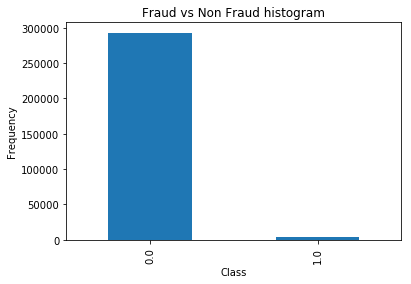

In [25]:
counts = train.fraud.value_counts()
nonfraud = counts[0]
isfraud = counts[1]
ratio_nonfraud = (nonfraud / (nonfraud + isfraud))*100
ratio_isfraud = (isfraud /(nonfraud + isfraud))*100
print('{} non-fraudulent transactions ({:.1f}%) & {} fraudulent transactions ({:.1f}%).'
      .format(nonfraud, ratio_nonfraud, isfraud , ratio_isfraud ))

# Visualizing 
pd.value_counts(df.fraud).plot.bar()
plt.title('Fraud vs Non Fraud histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df.fraud.value_counts()

This is a heavily imbalanced data. In section 3, we will use ** resampling method** on train set to detect fraudulent transactions more accurately ! 

#### relationship between numerical variables and target variable 

In [104]:
corr = df.corr()
corr 

,amount,fraud,id,time
amount,1.000000,0.488978,-0.001362,-0.007956
fraud,0.488978,1.000000,-0.000028,-0.008353
id,-0.001362,-0.000028,1.000000,0.001272
time,-0.007956,-0.008353,0.001272,1.000000


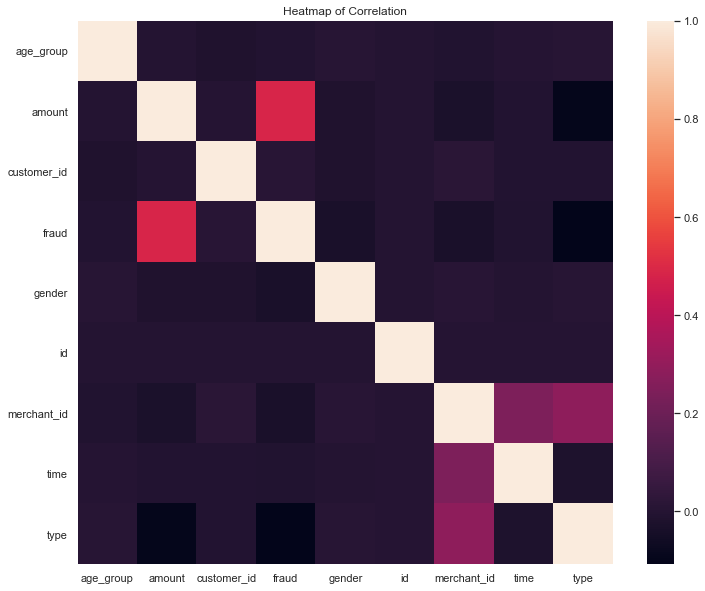

In [507]:
#heatmap to visualize the correlation between features 
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

The strongest correlation is between 'fraud' and 'amount' features (0.49).

In [115]:
# split train set into non fraud df & fraud df
nonfrauddf =  df.loc[df.fraud == 0]
frauddf = df.loc[df.fraud == 1]

# summary statistics of non fraud  & fraud amount to check the difference
print(nonfrauddf.amount.describe())
print(frauddf.amount.describe())

count    293052.000000
mean         31.737868
std          31.492320
min         -10.000000
25%          13.580000
50%          26.550000
75%          41.760000
max        1993.680000
Name: amount, dtype: float64
count    3456.000000
mean      538.237266
std       850.297893
min         0.110000
25%       158.882500
50%       319.685000
75%       551.980000
max      7635.410000
Name: amount, dtype: float64


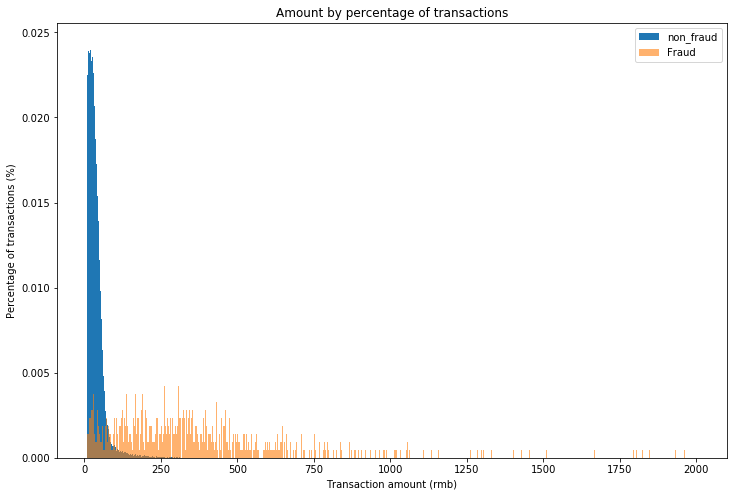

In [68]:
#plot of transaction amount
bins = np.linspace(10, 2000, 3000)
plt.figure(figsize=(12,8))
plt.hist(nonfrauddf.amount, bins, alpha=1, normed=True,  label='non_fraud')
plt.hist(frauddf.amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions")
plt.xlabel("Transaction amount (rmb)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

- From heatmap, we can tell that feature 'fraud' is related with 'amount'. 
- From the summary statistics, the average transaction amount of 1.2% fraudulent transactions in train set is 538.2 rmb, which is extremely higher than average non-fraudulent transaction amount, 31.5 rmb. Standard deviation (850.3) for fraud class is large. 
- From the plot, we can observe that normal transactions are mostly low-value transactions, while fraudulent transactions are in wide range from 0 rmb to 7635 rmb.

Thus, we could claim that the two classes (fraud vs non_fraud) come from populations with distinct means and deviations. They have different patterns.

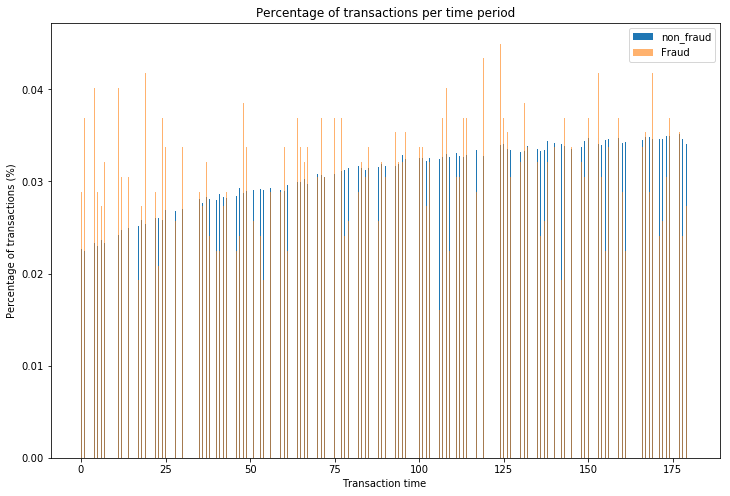

In [69]:
bins = np.linspace(0, 180, 1000)
plt.figure(figsize=(12,8))
plt.hist(nonfrauddf.time, bins, alpha=1, normed=True,  label='non_fraud')
plt.hist(frauddf.time, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions per time period")
plt.xlabel("Transaction time ")
plt.ylabel("Percentage of transactions (%)")
plt.show()

We can sightly see that fraudulent transaction from time 0 to time 25 has higher ratio than other periods of time. There is constant increasing in normal transaction from time 0 to time 180.

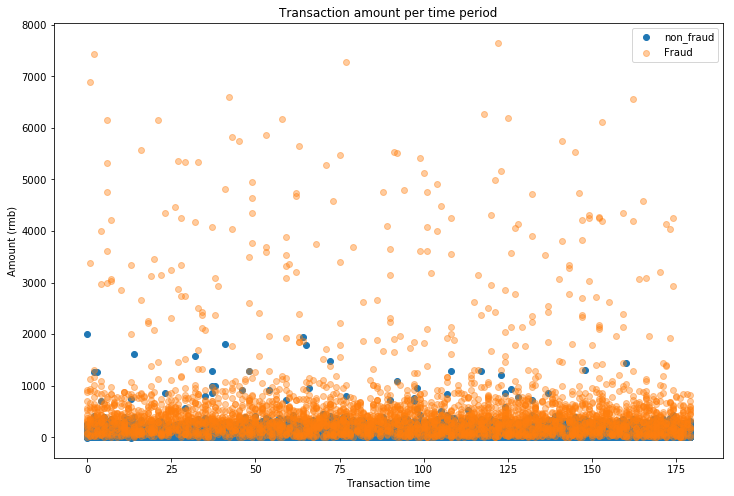

In [79]:
plt.figure(figsize=(12,8))
plt.scatter(nonfrauddf.time, nonfrauddf.amount, alpha= 1, label='non_fraud')
plt.scatter(frauddf.time, frauddf.amount, alpha=0.4, label='Fraud')
plt.title("Transaction amount per time period")
plt.xlabel("Transaction time")
plt.ylabel('Amount (rmb)')
plt.legend(loc='upper right')
plt.show()

- From heatmap, we observe that 'time' is not significant related to 'fraud' 
- From two plots above, we can't see there is a trend pattern of fraudulent transaction throughout the time periods so 'time' will be dropped in our data. Thus, we assume that fraud is **'time independent'** in our case.    

#### relationship between categorical variables and target variable 

In [113]:
# For testing if two features are independent or not

# H0: A and B are independent --> holds if p_value > treshold
# H1: A and B are dependent --> holds if p_value < treshold
    
from scipy.stats import chi2_contingency

csq = chi2_contingency(pd.crosstab( train.fraud , train.age_group))
print("fraud & age_group P-value: ",csq[1])

csq2 = chi2_contingency(pd.crosstab(train.fraud , train.gender))
print("fraud & gender P-value: ",csq2[1])

csq3 = chi2_contingency(pd.crosstab(train.fraud , train.type))
print("fraud & type P-value: ",csq3[1])

fraud & age_group P-value:  1.2376426404215477e-16
fraud & gender P-value:  2.3071618820478577e-72
fraud & type P-value:  0.0


P values for categorical features **age_group, gender, and type** are very small, which we can reject Ho. It indicates that these features are dependent and related to 'fraud' variable. Thus, now let's check for their relationship. 

#### types vs merchants vs fraud

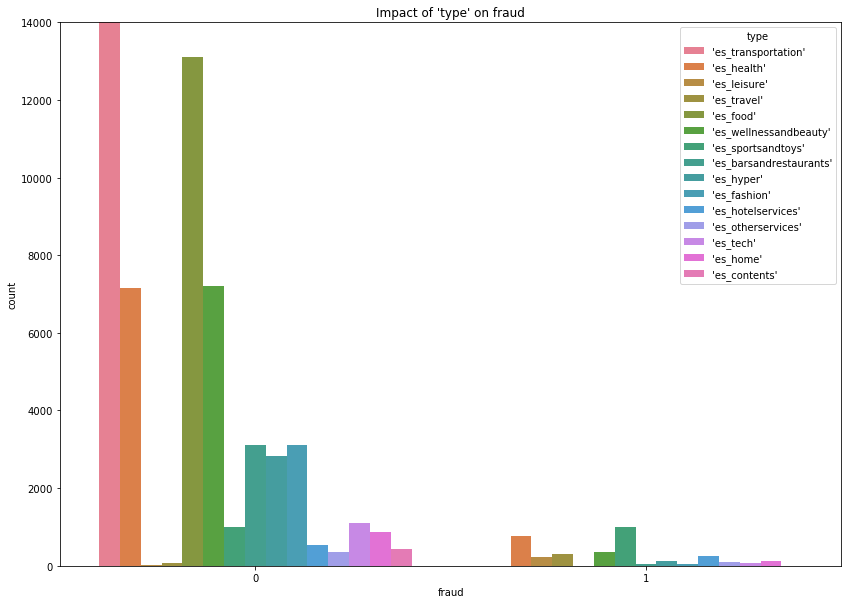

In [133]:
fig, ax=plt.subplots(figsize=(14,10))
sns.countplot(x='fraud', data = train, hue='type', palette = 'husl')
ax.set_ylim(0,14000)
plt.title("Impact of 'type' on fraud")
plt.show()

In [144]:
num_f_m =(
    frauddf
    .groupby('type')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'num_fraud_trans'})
)

total_m = (
    train.groupby('type')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'total_trans'})
)

type_m = pd.merge(num_f_m , total_m, on='type', how='outer').fillna(0)
type_m['ratio_t_f_m'] = type_m.num_fraud_trans / type_m.total_trans
type_m

,type,num_fraud_trans,total_trans,ratio_t_f_m
0,'es_barsandrestaurants',58.0,3172,0.018285
1,'es_fashion',58.0,3177,0.018256
2,'es_tech',75.0,1173,0.063939
3,'es_otherservices',110.0,456,0.241228
4,'es_hyper',133.0,2972,0.044751
5,'es_home',136.0,996,0.136546
6,'es_leisure',234.0,242,0.966942
7,'es_hotelservices',259.0,805,0.321739
8,'es_travel',297.0,372,0.798387
9,'es_wellnessandbeauty',346.0,7551,0.045822


- From the plot, we can see the largest number of transactions in train data are from **'transportation' and 'food'** types; however, there is no fraudulent transactions in these two types. **'es_contents'** also has no fraudulent transactions. In other words, we may miss to classify fraudulent transactions if only given the information of these three types. 


- 97% of merchants from **'es_leisure'** type have fraudulent transactions. Around 80% of merchants from **'es_travel'** type have fraudulent transactions. **'es_sportsandtoys' and 'es_hotelservices'** are another two types that have high probably (50% & 32%) of making fraudulent transactions. Thus, we could better capture fraud patterns from these types since we were given more information of the fraudulent transactions. From other point of view, we should investigate more on these 4 types to prevent fraudulent transactions.

#### age_groups vs merchants vs fraud

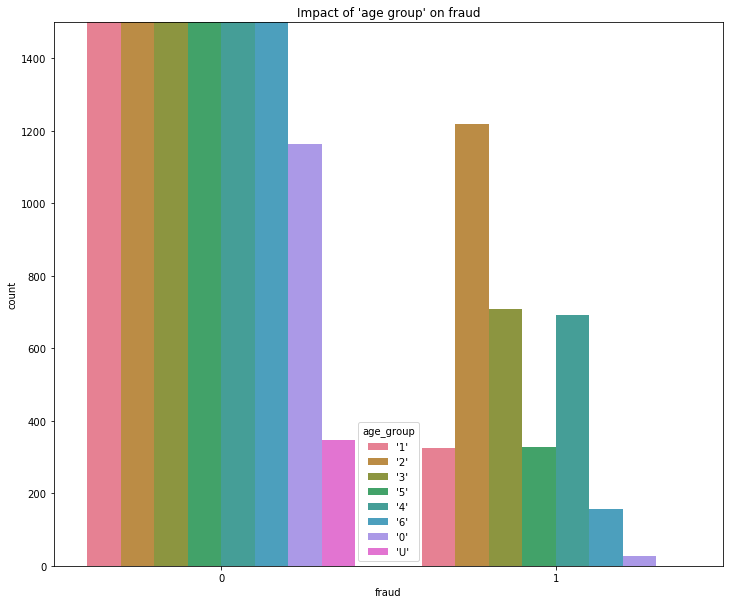

In [155]:
fig, ax=plt.subplots(figsize=(12,10))
sns.countplot(x='fraud', data = train, hue='age_group', palette = 'husl')
ax.set_ylim(0,1500)
plt.title("Impact of 'age group' on fraud")
plt.show()

In [499]:
# Create a data frame, rename the size column and assign the resulting data frame to a new variable.
num_f_m =(
    frauddf
    .groupby('age_group')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'num_fraud_trans'})
)

total_m = (
    train.groupby('age_group')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'total_trans'})
)

age_m = pd.merge(num_f_m , total_m, on='age_group', how='outer').fillna(0)
age_m['ratio_f_m'] = age_m.num_fraud_trans / age_m.total_trans
age_m

,age_group,num_fraud_trans,total_trans,ratio_f_m
0,'0',26.0,1191,0.022
1,'6',158.0,15061,0.010
2,'1',324.0,30369,0.011
3,'5',327.0,34484,0.009
4,'4',693.0,50387,0.014
5,'3',709.0,71845,0.010
6,'2',1219.0,92825,0.013
7,'U',0.0,346,0.000


Age groups **'2','3','4'** with the top three highest number of transactions and fraudulent transactions have similar ratio of encountering fraudulent transactions. However, age group **'0'** with the second last number of transactions has the highest ratio of encountering fraudulent transactions.

####  genders vs merchants vs fraud

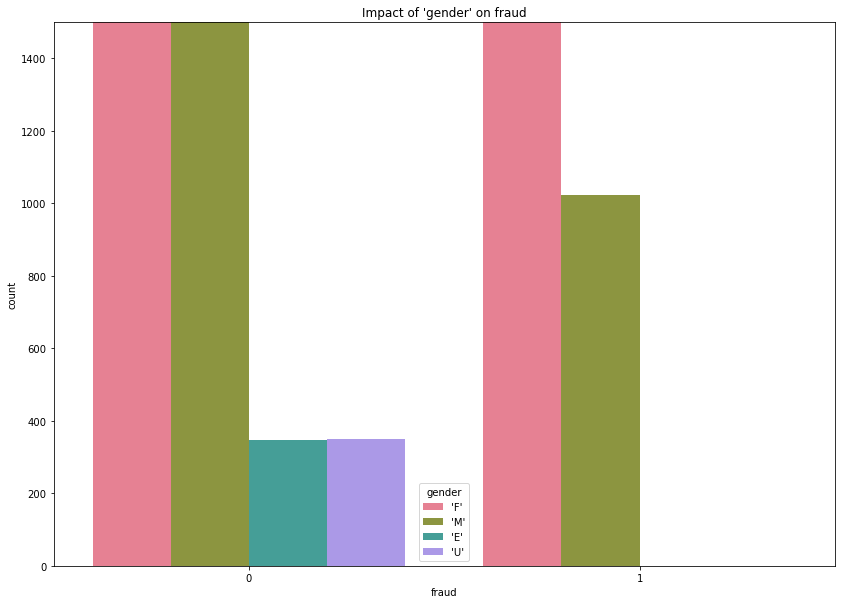

In [157]:
fig, ax=plt.subplots(figsize=(14,10))
sns.countplot(x='fraud', data = train, hue='gender', palette = 'husl')
ax.set_ylim(0,1500)
plt.title("Impact of 'gender' on fraud")
plt.show()

In [498]:
# Create a data frame, rename the size column and assign the resulting data frame to a new variable.
num_f_m =(
    frauddf
    .groupby('gender')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'num_fraud_trans'})
)

total_m = (
    train.groupby('gender')['merchant_id']
    .size()
    .sort_values()
    .reset_index()
    .rename(columns = {'merchant_id': 'total_trans'})
)

gender_m = pd.merge(num_f_m , total_m, on='gender', how='outer').fillna(0)
gender_m['ratio_f_m'] = gender_m.num_fraud_trans / gender_m.total_trans
gender_m

,gender,num_fraud_trans,total_trans,ratio_f_m
0,'M',1023.0,132495,0.008
1,'F',2433.0,163316,0.015
2,'E',0.0,346,0.000
3,'U',0.0,351,0.000


**Female customer** may be more likely to encounter fraudulent transactions than other gender. 

In [ ]:
fig, ax=plt.subplots(figsize=(14,10))
sns.countplot(x='fraud', data = train, hue='merchant_id', palette = 'husl')
ax.set_ylim(0,14000)
plt.title("Impact of 'merchat' on fraud")
plt.show()

#### merchants VS. customers 

In [3]:
subset = df[['customer_id', 'merchant_id']]
temp = subset.groupby('customer_id').merchant_id.apply(lambda x: x.value_counts())
temp.head()

customer_id                 
'C1000148617'  'M1823072687'    92
               'M348934600'     22
               'M85975013'       5
               'M1888755466'     2
               'M1400236507'     1
Name: merchant_id, dtype: int64

In [4]:
fraud_unstack = temp.unstack().fillna(0) #will be used for creating adjlist in section 3 
fraud_unstack.tail() 

,'M1053599405','M117188757','M1198415165','M1294758098','M1313686961','M1352454843','M1353266412','M1400236507','M1416436880','M151143676',...,'M732195782','M78078399','M840466850','M855959430','M857378720','M85975013','M923029380','M933210764','M97925176','M980657600'
customer_id,,,,,,,,,,,,,,,,,,,,,
'C99729647',2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,2.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0
'C998690782',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,2.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0
'C998987490',6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0
'C999393223',2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,4.0,0.0,6.0,0.0,0.0,2.0,0.0
'C999723254',2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0


In [5]:
fraud_unstack.shape  #4112 customers with 50 merchants 

(4112, 50)

In [6]:
customer_activation = fraud_unstack.sum(axis = 1)
customer_activation.describe()

count    4112.000000
mean      144.611625
std        42.788212
min         5.000000
25%       130.000000
50%       165.000000
75%       173.000000
max       265.000000
dtype: float64

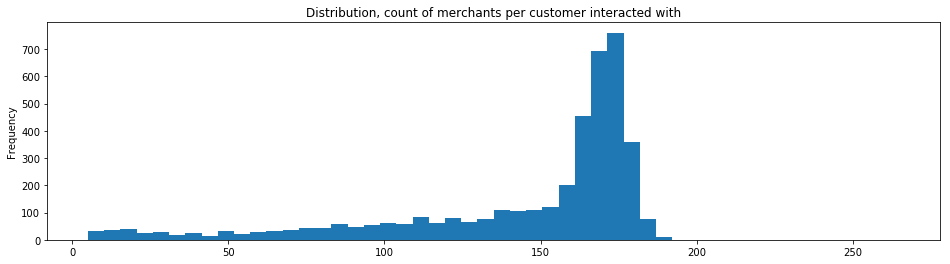

In [7]:
customer_activation.plot(kind = 'hist',bins = 50,figsize = (16,4),title = 'Distribution, count of merchants per customer interacted with')
plt.show()

Average 144 merchants (std 43 merchants) that each customer interacted within the 180 time periods. 

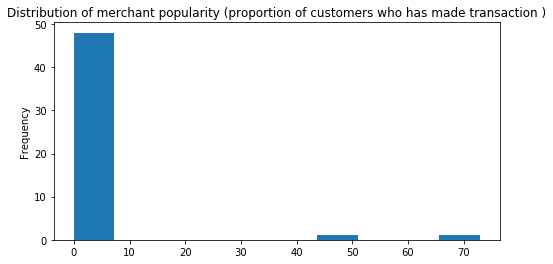

In [8]:
merchant_popularity = fraud_unstack.mean(axis = 0)
merchant_popularity.plot(kind = 'hist',figsize = (8,4),title = 'Distribution of merchant popularity (proportion of customers who has made transaction )')
plt.show()

In [9]:
merchant_popularity.describe()

count    50.000000
mean      2.892232
std      12.325473
min       0.000730
25%       0.062257
50%       0.146766
75%       0.448261
max      72.882539
dtype: float64

In [104]:
df1823072687 = df.loc[(df.merchant_id == 1823072687) ]
df348934600 = df.loc[(df.merchant_id == 348934600) ]
df1823072687.describe()
df348934600.describe()

,age_group,amount,customer_id,fraud,gender,id,merchant_id,time,type
count,205426.000000,205426.000000,2.054260e+05,102204.0,205426.000000,205426.000000,205426.0,205426.000000,205426.0
mean,3.038252,26.965261,1.069688e+09,0.0,1.448288,148435.669696,348934600.0,76.615823,12.0
std,1.354382,17.526558,6.173859e+08,0.0,0.502171,85766.766422,0.0,50.700202,0.0
min,0.000000,-1.200000,9.535600e+04,0.0,0.000000,0.000000,348934600.0,0.000000,12.0
25%,2.000000,12.840000,5.501908e+08,0.0,1.000000,74225.750000,348934600.0,32.000000,12.0
50%,3.000000,24.980000,1.078317e+09,0.0,1.000000,148371.000000,348934600.0,71.000000,12.0
75%,4.000000,38.650000,1.597977e+09,0.0,2.000000,222568.750000,348934600.0,117.000000,12.0
max,7.000000,118.070000,2.145933e+09,0.0,3.000000,298133.000000,348934600.0,179.000000,12.0


M1823072687 & M348934600 are the only two merchants that have over 44% populatity in data. They are labeled as normal transportation transactions. 

#### merchants vs fraud

In [380]:
size_merchant_fraud = train.groupby(['merchant_id','fraud']).size()
size_merchant_fraud.head(20) 

merchant_id    fraud
'M1053599405'  0        3377
'M117188757'   0          11
'M1198415165'  0         604
               1         185
'M1294758098'  0           2
               1         100
'M1313686961'  0         242
'M1352454843'  0         166
'M1353266412'  0           7
               1          29
'M1400236507'  0         398
'M1416436880'  0         112
'M151143676'   0        3114
               1          58
'M1535107174'  0         838
               1          79
'M1600850729'  0        1303
'M1649169323'  0         511
               1          69
'M1726401631'  0           2
dtype: int64

In [370]:
size_merchant_fraud = frauddf.groupby(['merchant_id','fraud']).size()
size_merchant_fraud.shape 

(30,)

- There are **60%** merchants in train data have encountered fraudulent transactions. In these 30 merchants, we can see merchant 'M1294758098' has the fraud ratio 98%, while for merchant 'M1535107174' the fraud ratio is 2%. 


- Since the fraud ratio of merchants is in wide range, there are many possibilities of fraud patterns from different sources targeting diverse backgrounds' customers. The fraud patterns is hard to observe directly. 

#### customers VS. fraud

In [378]:
size_customer_fraud = train.groupby(['customer_id','fraud']).size()
size_customer_fraud.tail(10) 

customer_id   fraud
'C995746715'  0        104
              1          2
'C996326258'  0        125
'C996804095'  0        172
              1          1
'C99729647'   0        175
'C998690782'  0        169
              1          2
'C999723254'  0        121
              1          1
dtype: int64

In [377]:
size_customer_fraud = frauddf.groupby(['customer_id','fraud']).size()
size_customer_fraud.shape 

(740,)

In [379]:
train.customer_id.nunique()

2056

We have **36% of customers** in train data have encountered fraudulent transactions, which is pretty high ratio. 

story: Customers are more likely to buy again from a merchant selling snacks than from a merchant selling electronic products within time period, since snacks are cheaper and are consumed much faster than electronic products. 


# 2.  👨🏻‍🔧 Feature Engineering 

Feature engineering is a crucial step to build an effective fraud detection model that can extract patterns of fraudulent behaviours. Thus, we need to select and create useful features as input for model to better identify the behaviour patterns of customers and merchants in order to capture the hidden fraudulent behaviours.

We have **customers and merchants** as entities in data. To generate features that describe these entities' characteristics and their pair-wise interactions can be useful information to predict the target feature. 


## 2.1 Selecting & transforming raw features
Raw feature, such as **id **, is excluded in modeling part since they cannot be directly used as model inputs.  

Place of the transaction including **zipcode_customer and zipcode_merchant** are removed since all customers and merchants are from the same place. 

We keep both numeric feature,**'amount'**, but drop **'time'**. We explained the reasons previously.

We also keep categorical features, **'age_group','gender', and 'type'**, since these are background information of customers.

In [ ]:
# normalizing numerical feature, amount 
from sklearn.preprocessing import StandardScaler

df['normAmount'] = StandardScaler().fit_transform(df['amount'].reshape(-1, 1))
df = df.drop(['amount'], axis=1)

# convert a column to a category and label encoding
df["age_group"] = df["age_group"].astype('category')
df["type"] = df["type"].astype('category')
df["gender"] = df["gender"].astype('category')
df["age_group"] = df["age_group"].cat.codes
df["type"] = df["type"].cat.codes
df["gender"] = df["gender"].cat.codes

df['merchant_id'] = df['merchant_id'].str.replace('M', '').str.replace("'", '').astype(int)
df['customer_id'] = df['customer_id'].str.replace('C', '').str.replace("'", '').astype(int)

# Both zipcode_customer and zipcode_merchant are value of 594643, customers and merchants are from the same place. 
# We drop these two features from dataset.
df = df.drop(['zipcode_customer', 'zipcode_merchant'], axis=1)

#save transform df to csv and then merge with embeddings
df.to_csv('fullset.csv')

## 2.2 Embedding merchant_id based on customer_id 

** GOAL: ** Create 50 vertex representations in dimensions of 16 for 50 distinct merchants based on customers' transaction behaviour  

** Background: ** Node embedding methods possess three properties that are suitable to solve the major problems in recommender system composing large networks of customers, merchants, items, and other features. First, the low-dimensional vector space provides the scalability for real-world social networks to be processed in short period of time. The time-consuming and scalability problem solved. Secondly, the informatic representations can capture potential connections between vertices in low-dimensional space. The sparsity problem solved. Thirdly, the undirect-connected merchants could be recommended to customers if they are the neighbours of the customers’ favour merchants. We can efficiently measure the distance between the embedding vectors. The neighbourhoods structure problem solved.

** Embedding Methods: **  In this project, merchant vertex representations are learned based on random walks under unsupervised manner. I choose simple random walk-based method, **DeepWalk**, since it is efficient for large-scale social network scenarios. Firstly, the short random walk sequences provide the concept of ‘nearness’, which helps to capture the neighbourhood structure of vertices without computing the global structure of the graph. Secondly, each short random walk sequence can efficiently be generated at the same time. 

** DeepWalk: ** Use Random Walk and Skip-Gram to learn potential latent neighbourhood of vertex <img src="DeepWalk.png">  
DeepWalk is a way to encode the potential relation of vertices to learn the matrix of vertex representations 𝜙: 𝑣 ∈
𝑉 ⟼ R^(|v|*d)" in low-dimension d (Figure e). Its input is stream of vertex sequences 𝑊 that are generated from truncated random walks (Figure c). Each vertex 𝑣 in the sequences 𝑊vi with length t, {𝑣1 ... 𝑣t}, is used to predict its contexts, which are the vertices within its window size w. Vertex 𝑣i’s contexts, also mean neighbor vertices, 𝑣i-w ... 𝑣i+w, may not link directly with 𝑣i in the original graph, but through w steps random walks in graph, these contexts indirectly link and co- occur with 𝑣i (Figure d). 𝑣i ′𝑠 local neighborhood structure then formed. If vertices have higher probability co-occur on the random walks sequence, their latent representations 𝜙 tend to be similar. 


In the DeepWalk algorithm, the outer loop is based on 𝛾, the number of starting random walks on each vertex. For instance, if 𝛾 is 2, each vertex in graph has twice times to be the starting point for random walks. The inner loop will go through all vertices in graph to make sure that each vertex is sampled for random walk at least once.


For each vertex 𝑣i in the vertex sequences 𝑊v , **Skip-Gram** predicts 𝑣i′𝑠 context vertices, {𝑣i-w, ..., 𝑣i+w}. Given the latent representation of 𝑣i, 𝜙(𝑣i), we maximize the probability that its neighbors will co- occur (Figure d).

** Further improvement:** I could also use **Node2vec** to learn embeddings since it is more flexibile random walks node embedding method with parameter p & q and the network can be presented with direction and weight.

### 2.2.1 creat adjcent list

The adjcent list is created by collection of (unordered) transaction lists that each customer_id has made. They represent a finite merchant - interaction graph.

Each list describes the set of neighbors (merchants that share common features in some degrees) of a vertex (merchant) in the graph (network) based on customers' behaviors.

In [187]:
df.merchant_id.shape

(594643,)

In [53]:
subset = df[['merchant_id', 'customer_id']]
temp1 = subset.groupby('customer_id').merchant_id.apply(lambda x: sorted(x.values))
temp1.head()

customer_id
'C1000148617'    [45060432, 85975013, 85975013, 85975013, 85975...
'C100045114'     [78078399, 78078399, 78078399, 85975013, 85975...
'C1000699316'    [85975013, 85975013, 85975013, 85975013, 85975...
'C1001065306'    [17379832, 17379832, 50039827, 50039827, 50039...
'C1002658784'    [17379832, 78078399, 85975013, 85975013, 85975...
Name: merchant_id, dtype: object

In [54]:
len(list(temp1[0]))

131

In [55]:
temp = df.groupby('customer_id').merchant_id.apply(lambda x: x.value_counts())
temp.head()

customer_id              
'C1000148617'  1823072687    92
               348934600     22
               85975013       5
               1888755466     2
               1400236507     1
Name: merchant_id, dtype: int64

 'C1000148617' customer has made transactions with 131 merchants in history.  92 transactions from 'M1823072687', 22 transactions from 'M348934600', 8 transactions from 3 other merchants. 

In [43]:
adj_l = []
for col in fraud_unstack.columns:
    sub = fraud_unstack[fraud_unstack[col] == 1]
    sub = sub.drop(col,axis = 1)
    neibours = sub.columns[sub.sum(axis = 0) != 0]
    neibours_str = ' '.join(neibours.map(str))
    adj_row = str(col)+' '+neibours_str
    adj_l.append(adj_row)

In [44]:
adjlist = pd.Series(adj_l)
adjlist.head()

0    3697346 17379832 45060432 50039827 78078399 85...
1    17379832 3697346 45060432 50039827 78078399 85...
2    45060432 3697346 17379832 50039827 78078399 85...
3    50039827 3697346 17379832 45060432 78078399 85...
4    78078399 3697346 17379832 45060432 50039827 85...
dtype: object

In [45]:
len(adjlist[0])

495

In [46]:
adjlist[0]

'3697346 17379832 45060432 50039827 78078399 85975013 97925176 151143676 209847108 348875670 348934600 349281107 480139044 495352832 547558035 677738360 692898500 732195782 840466850 855959430 857378720 923029380 933210764 980657600 1053599405 1198415165 1294758098 1313686961 1352454843 1353266412 1400236507 1416436880 1535107174 1600850729 1649169323 1741626453 1748431652 1788569036 1823072687 1842530320 1872033263 1873032707 1888755466 1913465890 1946091778 2011752106 2080407379 2122776122'

In [47]:
type(adjlist)

pandas.core.series.Series

customers made transactions with merchant 0 also made transactions with 638 other merchants, such as 'M1053599405' 'M117188757' 'M1198415165' 'M1294758098' 'M1313686961' 'M1352454843' 'M1353266412' 'M1400236507' 'M1416436880' 'M151143676' 'M1535107174' .... .

In [49]:
adjlist.to_csv('merchant.adjlist',index=False)

### 2.2.2 Deepwalk Embeddings 
DeepWalk github: https://github.com/phanein/deepwalk 

### Parameter Setting w/ Steps

--input: movies.adjlist
--format adjlist for an adjacency list


deepwalk  --input merchant.adjlist --number-walks 80 --representation-size 16 --walk-length 80 --window-size 10 --output merchant.embeddings

Number of nodes: 50
Number of walks: 4000
Data size (walks*length): 320000
Walking...
Training...

--output: Merchant.embeddings
The output representations in skipgram format - first line is header, all other lines are node-id and d dimensional representation


#### 🥳 Awesome  !  We get merchant.embeddings file 🍻 ! 

In [10]:
embeddings = pd.read_csv('merchant.embeddings',delimiter=' ',header = None, skiprows=[0])
embeddings = embeddings.rename(columns = {0: 'merchant_id'})
embeddings.columns = ['embedded_'+str(i) for i in embeddings.columns]
#embeddings = embeddings.set_index('MovieID')
embeddings.shape

(50, 17)

In [11]:
embeddings = embeddings.rename(columns = {'embedded_merchant_id':'merchant_id'})
embeddings.tail()

,merchant_id,embedded_1,embedded_2,embedded_3,embedded_4,embedded_5,embedded_6,embedded_7,embedded_8,embedded_9,embedded_10,embedded_11,embedded_12,embedded_13,embedded_14,embedded_15,embedded_16
45,1353266412,-0.031741,-0.153732,0.170732,-0.158606,-0.159732,0.075313,-0.096302,0.241374,0.159765,-0.063444,0.053756,-0.109712,-0.213686,-0.106282,-0.103340,0.156456
46,1416436880,-0.117973,-0.166427,0.215208,-0.060880,-0.149168,0.080850,0.002842,0.317571,0.227112,-0.150894,0.011594,-0.025987,-0.118185,-0.084987,-0.056226,0.166676
47,933210764,-0.126865,-0.118701,0.197929,-0.238377,-0.093262,0.013161,0.020054,0.183036,0.189182,-0.099792,0.040660,-0.088138,-0.345363,-0.080750,-0.073636,0.130643
48,117188757,-0.029902,-0.248048,0.147398,-0.148597,-0.215629,0.136755,-0.073142,0.188593,0.278521,-0.050181,-0.002270,0.002896,-0.207627,0.048820,-0.040075,0.231067
49,1726401631,-0.093656,-0.157700,0.098084,-0.115230,-0.297723,0.152683,-0.166218,0.105166,0.156830,-0.067620,0.006551,-0.055503,-0.188464,-0.222137,-0.082856,0.269031


DeepWalk maps 50 merchants into 50 low-dim vertex representations (dim of 16)

### 2.3 Creating useful features

In [52]:
import pandas as pd
FEdf = pd.read_csv('fullset.csv')

#### get gender ratio for each merchant

In [3]:
genders = FEdf[['merchant_id','gender']]
genders = genders.groupby('merchant_id').gender.apply(lambda x: x.value_counts()/len(x.values)).unstack().fillna(0.0)
genders.columns = ['gender_'+str(i) for i in genders.columns]
genders = genders.reset_index()
genders.head()

,merchant_id,gender_0,gender_1,gender_2,gender_3
0,3697346,0.000000,0.626623,0.373377,0.0
1,17379832,0.003546,0.652482,0.343972,0.0
2,45060432,0.005236,0.525305,0.469459,0.0
3,50039827,0.004367,0.603712,0.391921,0.0
4,78078399,0.002488,0.559701,0.437811,0.0


#### get age distribution for each merchant

In [14]:
ages = FEdf[['merchant_id','age_group']]
ages = ages.groupby('merchant_id').age_group.apply(lambda x: x.value_counts()/len(x.values)).unstack().fillna(0.0)
ages.columns = ['ages_'+str(i) for i in ages.columns]
ages = ages.reset_index()
ages.head(3)

,merchant_id,ages_0,ages_1,ages_2,ages_3,ages_4,ages_5,ages_6,ages_7
0,3697346,0.009740,0.116883,0.250000,0.295455,0.172078,0.110390,0.045455,0.000000
1,17379832,0.003546,0.095745,0.336879,0.219858,0.177305,0.106383,0.056738,0.003546
2,45060432,0.000000,0.099476,0.319372,0.253054,0.188482,0.101222,0.033159,0.005236


#### get fraud ratio for each merchant

In [15]:
fraud = FEdf[['merchant_id','fraud']].dropna(subset = ['fraud'])
fraud = fraud.groupby('merchant_id').fraud.apply(lambda x: x.value_counts()/len(x.values)).unstack().fillna(0.0)
fraud.columns = ['fraud_'+str(i) for i in fraud.columns]
fraud = fraud.reset_index()
fraud.head()
#len(fraud) is 50. All merchants are in train set  

,merchant_id,fraud_0.0,fraud_1.0
0,3697346,0.042857,0.957143
1,17379832,0.373239,0.626761
2,45060432,1.000000,0.000000
3,50039827,0.959459,0.040541
4,78078399,0.981906,0.018094


#### customer features

In [16]:
usersdf = FEdf[['customer_id','merchant_id']]
transaction_num = usersdf.groupby('customer_id').merchant_id.count()

users_features = pd.get_dummies(usersdf.set_index('customer_id'))

users_features['transaction_num'] = transaction_num 

users_features = users_features.drop('merchant_id',axis = 1).reset_index()
users_features.head() 

,customer_id,transaction_num
0,1734879586,178
1,1896147467,160
2,1590346257,169
3,16891369,168
4,635222317,175


#### Merge selected raw features, embeddings and created features

In [24]:
merchant_features = (embeddings.merge(genders,left_on = 'merchant_id',right_on = 'merchant_id',how = 'left')
                 .merge(ages,left_on = 'merchant_id',right_on = 'merchant_id',how = 'left')
                 .merge(fraud,left_on = 'merchant_id',right_on = 'merchant_id',how = 'left'))

full_set = FEdf.merge(merchant_features,left_on = 'merchant_id',right_on = 'merchant_id',how = 'left')
full_set = full_set.drop(['Unnamed: 0','id'],axis = 1)

full_set.to_csv('feature_set_embed.csv',index = False) 

## 3. 👩🏻‍🔬  Transaction Fraud Detection Model 

**🧪 Assumption:** We assume fraudulent transaction occurs is not depending on 'time'.


*NOTE: At first, I assumed fraudulent transaction is depending on time so I try RNN. However, the result performance is extremely worse. It might be that there are only 180 time periods in data, and I am not sure which transactions happened first in each period. I just simplied sort the data by 'time'. However, 'time' features definitely need further investigation if we can gather more sufficient infomation.  

####  load  'feature_set_embed.csv' that contains all the features as input for our models

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

modeldf = pd.read_csv('feature_set_embed.csv')
modeldf.head()

,age_group,customer_id,fraud,gender,merchant_id,time,type,normAmount,embedded_1,embedded_2,...,ages_0,ages_1,ages_2,ages_3,ages_4,ages_5,ages_6,ages_7,fraud_0.0,fraud_1.0
0,1,1734879586,0.0,1,348934600,18,12,-0.124411,-0.032155,-0.166616,...,0.003300,0.094813,0.322072,0.236036,0.182153,0.10912,0.050563,0.001942,1.0,0.0
1,2,1896147467,0.0,1,1823072687,125,12,0.028637,-0.132469,-0.209461,...,0.004278,0.100029,0.309864,0.254324,0.183681,0.10404,0.041863,0.001922,1.0,0.0
2,1,1590346257,0.0,1,348934600,7,12,-0.002691,-0.032155,-0.166616,...,0.003300,0.094813,0.322072,0.236036,0.182153,0.10912,0.050563,0.001942,1.0,0.0
3,3,16891369,0.0,2,348934600,66,12,0.122979,-0.032155,-0.166616,...,0.003300,0.094813,0.322072,0.236036,0.182153,0.10912,0.050563,0.001942,1.0,0.0
4,3,635222317,0.0,1,1823072687,140,12,-0.159060,-0.132469,-0.209461,...,0.004278,0.100029,0.309864,0.254324,0.183681,0.10404,0.041863,0.001922,1.0,0.0


**NOTE** : evaluating the score of test set isn't available since real **y_test** isn't provided. However, we can split the orginial train set into 80% train and 20% valid and then evaluate the score of valid set.

In [27]:
# drop 'time'
modeldf = modeldf.drop('time',axis = 1)

# split into train, valid and test
from sklearn.model_selection import train_test_split
train_new = modeldf[:296508]
Ytrain = train_new['fraud'] 
Xtrain = train_new.drop('fraud',axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, Ytrain, test_size = 0.2 , random_state = 42)

X_testdf = modeldf[296508 :].drop('fraud',axis = 1)
X_test = modeldf[296508 :].drop('fraud',axis = 1)

# X_valid.shape  (59302, 36)
# X_train.shape  (237206, 36)
# X_test.shape   (298135, 36)

X_testdf = X_testdf.reset_index() # later will merge with y_predicted 

###  3.1 Resampling methods for imbalanced data 
- Undersampling : reduces samples from the majority class

- Oversampling : add samples to the minority class

We apply one of the oversampling methods, **Synthetic Minority Over-sampling Technique (SMOTE)**, since it creates new synthetic fraud samples that are similar to the existing ones by 𝑘-nearest neighbours approach rather than just copies the existing ones. <img src="Oversampling_SMOTE.png"> 

🍻 We make the ratio of label 1.0 in train set from **1.2% to 50%**. 🥰 The imbalance problem solved.

In [28]:
# apply  SMOTE to train set
from imblearn.over_sampling import SMOTE
method = SMOTE(kind='borderline2')
S_X_train, S_y_train = method.fit_sample(X_train, y_train)

# check count of non-fraud vs fraud
unique, counts = np.unique(y_train, return_counts=True) # (array([0., 1.]), array([234431,   2775]))

# check count of non-fraud vs fraud after applying SMOTE
unique, counts = np.unique(S_y_train, return_counts=True) #(array([0., 1.]), array([234431, 234430]))

### 3.2 Evaluation metrics 
In the case of fraud detection, 

- ** False Positives OK 👌. **  It is OK if we accidentally detect some transactions that are not fraud. In other words, we are not very interested in how the model performs on the non-fraudulent transactions (labeled as negative). However, it is also annoying if we are sending out too many notifications about their transactions without them being fraud. Thus, we also don’t want to sacrificing too much **precision** TP / (TP + **FP**).
     

- ** False Negatives NOT OK 😢. ** Out of all the fraudulent transactions (labeled as positive), we need to correctly detect them as fraud. It is NOT OK to miss detecting fraud one as non-fraud. Thus, this is a model that care more about **recall**. We focus on TP/(TP + **FN**) % of the fraudent transactions were retrieved.


#### Metric: 

- **PR AUC, average_precision_score :** Average Precision (AP) Score document retrieval.  AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. <img src="AP.png"> 

Overall, we don't care how many of the **negative predictions** are correct, but we want as many as the **positive predictions** are correct. 

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score


def metric(classifier,predictions, scores):
    cm = confusion_matrix(y_valid, predictions)
    
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall + precision)
    
    average_precision = average_precision_score(y_valid, scores)

    print('Recall={0:0.1f}'.format(recall),'\nPrecision={0:0.1f}'.format(precision))
    print('F1={0:0.1f}'.format(F1))
    print('Average precision-recall score: {0:0.1f}'.format(average_precision))

### 3.3 Imbalanced Binary Classification Task Models

We train classification models, including Logistic Regression(baseline), **Random Forest, XGBoost**, and Multi Layer Perceptron. 

#### Why focus on  tree ensemble methods ?  
We focus on tree ensemble methods because they are **scalable**, which can handle sparse data (e.g. one-hot encoding categorical feaures) and learn higher order interaction between features.


- **Decision tree algorithms 🌲 🌳 :** Splitting rules force both classes of the features to be addressed. Thus, imbalanced datasets with small ratio of positive samples can also be identified. 
- **Ensemble models 🌳🌲🌳 🌳🌲 : ** training multiple weak classifiers to form one strong classifier helps reduce errors. 
   - **Bagging method: ** reduces variance. 
   - **Boosting method:** reduces bias of the final model. 

#### 3.3.1 Logistic Regression model (Baseline) combined with SMOTE

We choose LR as our baseline since it is more **interpretable** and **faster**. It can also be seen as single level perception with sigmoidal activation function. LR learns the relations between input features and the target feature. However, since prediction depends on the sum of the inputs and parameters (weights), it is necessary to select relevant features and create informatic features. Otherwise, the result of prediction would be worse.

In [10]:
# valid with score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 42)

# Fit a LR model & SMOTE 
model.fit(S_X_train, S_y_train) 

# model predictions
LR_SMOTE_predicted = model.predict(X_valid)

# Predict_proba will give the only probability of 1
scores = model.predict_proba(X_valid)[:,1]
metric(model, LR_SMOTE_predicted, scores)
print("Non Zero weights:",np.count_nonzero(model.coef_))

Recall=0.5 
Precision=0.0
F1=0.0
Average precision-recall score: 0.0
Non Zero weights: 36


In [11]:
# test set with LR_SMOTE_predicted for further evaluating with y_test
model = LogisticRegression(random_state = 42)

# Fit a LR model & SMOTE 
model.fit(S_X_train, S_y_train) 

# model predictions
LR_SMOTE_predicted = model.predict(X_test)

# count numbers of 1 & 0 
unique_elements  = np.unique(LR_SMOTE_predicted, return_counts=True)
unique_elements

(array([0., 1.]), array([178248, 119887]))

From the result, we can tell LR doesn't perform pretty well. Only 40% of the fraudent transactions were retrieved and it sacrificed too much precision. 

Our input features are not that informatic to discover fraud. Thus, we need to invest more time on **feature engineering** and check the **feature importance** (This may take times so we move to tree based methods.👇🏼 )

#### 3.3.2 Random Forest model combined with SMOTE

RF is one of the decision tree algorithms that based on Bagging method. It selects n number of **random subsets of bootstrap samples** and **random sets of m (max_features) number of features**, which decide the best split, and builds n (n_estimators) number of trees. As for these randomness, the bias of the forest do increases, but due to  max voting or averaging of less correlated trees, variance decreases. Resulted in a better model.

RF can be expected to outperform LR in our case. It can better handle higher dimensionality data, where one-hot encoding categorical features still be fine. All that said, we don't need careful feature engineering like LR does.

#### Optimizing key hyperparameters of a random forest by Grid Search 
- **n_estimators:** Number of trees we want to build before taking the max voting or averages of predictions.
- **max_features:** The number of features to consider when looking for the best split.

*NOTE: here, we will not focusing on param tuning due to time consuming  

In [12]:
# valid with score (without SMOTE)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# build a classifier
RFmodel = RandomForestClassifier(random_state=42)

# Fit a RF model & SMOTE 
RFmodel.fit(X_train, y_train) 

# model predictions
RF_predicted = RFmodel.predict(X_valid)

# Predict_proba will give the only probability of 1
scores = RFmodel.predict_proba(X_valid)[:,1]
metric(RFmodel, RF_predicted, scores)

Recall=0.8 
Precision=0.9
F1=0.8
Average precision-recall score: 0.8


In [13]:
# test set with RF_predicted for further evaluating with y_test

# build a classifier
RFmodel = RandomForestClassifier(random_state=42)

# Fit a RF model 
RFmodel.fit(X_train, y_train) 

# model predictions
RF_predicted = RFmodel.predict(X_test)

# count numbers of 1 & 0 
unique_elements  = np.unique(RF_predicted, return_counts=True)
unique_elements

(array([0., 1.]), array([295015,   3120]))

In [14]:
RF_predicted = pd.DataFrame(data= RF_predicted, columns=["RF_predicted"])
RF_predicted.shape

(298135, 1)

In [16]:
#list(train_new.columns.values)
feature_importances = pd.DataFrame(RFmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10) 

,importance
normAmount,0.352624
gender_1,0.130567
customer_id,0.116490
fraud_0.0,0.115494
fraud_1.0,0.112109
ages_0,0.029976
age_group,0.029213
gender_3,0.025688
embedded_5,0.012058
gender_2,0.011755


From feature importance, we can see that 'amount', 'gender', 'age_group' is related to target feature, which also confirm previous data analysis insight is correct.

In [17]:
# valid with score (add SMOTE)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# build a classifier
RFmodel = RandomForestClassifier(random_state=42)

# create param_grid dictionary                            
#param_grid = { 
#    'n_estimators': [200, 500], 
#    'max_features': ['auto', 'sqrt', 'log2'],
#}

# Run grid search
#RFmodel = GridSearchCV(estimator = RFmodel, param_grid = param_grid, cv= 5)

# Fit a RF model & SMOTE 
RFmodel.fit(S_X_train, S_y_train) 

# model predictions
RF_SMOTE_predicted = RFmodel.predict(X_valid)

# Predict_proba will give the only probability of 1
scores = RFmodel.predict_proba(X_valid)[:,1]
metric(RFmodel, RF_SMOTE_predicted, scores)

Recall=0.9 
Precision=0.7
F1=0.8
Average precision-recall score: 0.8


In [18]:
# test set with RF_SMOTE_predicted for further evaluating with y_test

# build a classifier
RFmodel = RandomForestClassifier(random_state=42)

# Fit a RF model & SMOTE 
RFmodel.fit(S_X_train, S_y_train) 

# model predictions
RF_SMOTE_predicted = RFmodel.predict(X_test)

# count numbers of 1 & 0 
unique_elements  = np.unique(RF_SMOTE_predicted, return_counts=True)
unique_elements

(array([0., 1.]), array([293985,   4150]))

In [19]:
RF_SMOTE_predicted = pd.DataFrame(data= RF_SMOTE_predicted, columns=["RF_SMOTE_predicted"])
RF_SMOTE_predicted.shape

(298135, 1)

🏅 RF may be a 👍 great classifier for fraud detection. It is OK that RF with SMOTE detected more fraudulent transactions than without SMOTE since our goal is to detect all fraudulent transactions. All metrics, Recall, Precision, F1, and average precision-recall score, are in great performance.

#### 3.3.3 XGBoost model combined with SMOTE

We choose XGBoost (extreme Gradient Boosting) as representation for Boosting method. It is an advanced implementation of Gradient Boosting and it is one of the most well performed Boosting method.

Boosting is another ensemble method, which learners are learned **sequentially** with prior learners by optimizing the error. However, it also aims at coverting weak learners into stronger learners.

In [ ]:
# valid with score (add SMOTE)

from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV

# build a classifier
xgbmodel = XGBClassifier(random_state = 42)

## create param_grid dictionary      
#param_grid = {'max_depth': [1,3,5], 
#             'n_estimators': [100,500,1000], 
#             'scale_pos_weight': [1, 0.1, 0.01]}


## Run grid search
#xgbmodel = GridSearchCV(estimator = xgbmodel, 
#                      param_grid = param_grid,
#                      scoring = 'f1', 
#                      cv = 10, 
#                      n_jobs = -1,
#                      refit = True)

#xgbmodel.fit(X_train, y_train)
#xgbmodel.best_params_


# Fit a xgb model & SMOTE 
xgbmodel.fit(S_X_train, S_y_train) 

# model predictions
xgb_SMOTE_predicted = xgbmodel.predict(X_valid)


# Predict_proba will give the only probability of 1
scores = xgbmodel.predict_proba(X_valid)[:,1]
metric(xgbmodel, xgb_SMOTE_predicted, scores)

Recall=1.0

Precision=0.5

F1=0.6

Average precision-recall score: 0.9

In [ ]:
# test set with xgb_SMOTE_predicted for further evaluating with y_test
from xgboost import XGBClassifier
# build a classifier
xgbmodel = XGBClassifier(random_state = 42)

# Fit a RF model & SMOTE 
xgbmodel.fit(S_X_train, S_y_train) 

# model predictions
xgb_SMOTE_predicted = xgbmodel.predict(X_test)

# count numbers of 1 & 0 
unique_elements  = np.unique(xgb_SMOTE_predicted, return_counts=True)
unique_elements #(array([0., 1.]), array([290304,   7831]))

In [ ]:
xgb_SMOTE_predicted = pd.DataFrame(data= xgb_SMOTE_predicted, columns=["xgb_SMOTE_predicted"])
xgb_SMOTE_predicted.shape #(298135, 1)

🎖 From the high ratio of fraud, parameter tuning seems to be a necessary step for XGBoost model. However, the XGBoost model does perfectly retrieve all fraudulent transactions (positive) in valid set, which **recall is 1.0**.

#### 3.3.4  Multi-layer perceptrons model  combined with SMOTE

MLP (multi-layer perceptrons) can use logistic as activation function in the layers, which is our baseline function. However, the tanh or ReLU function tend to work better in practice for the following reasons.

** hyperbolic tangent, tanh(𝑥) = 2σ(2𝑥)−1: **
- not limited to only positive outputs in the hidden layer(s): since the image is ∈{−1,1}.
- has stronger gradients (updates W & b much larger): since its max derivative, 1, is higher than sigmoid's 0.25.

** ReLU, 𝑓(𝑥) = max(0,𝑥): **
- speeding up training: gradient computation is very simple (either 0 or 1 depending on the sign of 𝑥).

** sigmoid (logistic), 𝜎(𝑥) = 1 / (1+𝑒^(−𝑘𝑥)): **
- makes more sense in the final layer of a binary classification network  since its image is ∈{0,1}.

In [23]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [24]:
#test with SMOTE

# define and fit the model
model = Sequential()
model.add(Dropout(0.2))
model.add(Dense(64, input_dim = 36, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# train model with SMOTE, 128 samples as a batch 
model.fit(S_X_train, S_y_train, epochs = 10, batch_size= 128)

# make a prediction
MLP_predicted = model.predict_proba(X_test)

Epoch 1/10
468862/468862 [==============================] - 6s 12us/step - loss: 7.7779 - acc: 0.5067
Epoch 2/10
468862/468862 [==============================] - 5s 11us/step - loss: 7.8071 - acc: 0.5093
Epoch 3/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7902 - acc: 0.5117
Epoch 4/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7779 - acc: 0.5130
Epoch 5/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7655 - acc: 0.5140
Epoch 6/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7449 - acc: 0.5156
Epoch 7/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7502 - acc: 0.5154
Epoch 8/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.7364 - acc: 0.5164
Epoch 9/10
468862/468862 [==============================] - 5s 10us/step - loss: 7.9085 - acc: 0.5045
Epoch 10/10
468862/468862 [==============================] - 5s 10us/step - loss: 

In [25]:
MLP_SMOTE_predicted = pd.DataFrame(data= MLP_predicted, columns=["MLP_SMOTE_predicted"])
MLP_SMOTE_predicted.MLP_SMOTE_predicted.value_counts()

1.0    298135
Name: MLP_SMOTE_predicted, dtype: int64

MLP model is more like experiment. The better hyperparmeter configuration definitely need to find.

### Testing file

In [ ]:
y_predicted_full_set  = pd.concat([RF_SMOTE_predicted, 
                                   RF_predicted, 
                                   xgb_SMOTE_predicted, 
                                   MLP_SMOTE_predicted,
                                   X_testdf], axis=1)

y_predicted_full_set.to_csv("y_predicted_full_set.csv")

For further experiment, we can also try **outlier detection method, OneClassSVM**. It is also a suitable model for imbalance data. Fraudulent transactions can be looked as 'outlier'. 

Ok, so done! ✅  👩🏻‍✈️   🚨  🧟‍♂️ 